# Airline Passenger Satisfaction Prediction
This project aims to predict passenger satisfaction for an airline based on various service and flight-related features. The goal is to identify factors influencing satisfaction and build a robust model that can predict whether a passenger will be "satisfied" or "neutral/dissatisfied." The insights gained can help the airline improve services and enhance customer experience.

## 1. Initial Setup & Data Loading

This section prepares the environment by importing all necessary Python libraries and configuring display options. It then loads the raw training and testing datasets from their respective file paths. An initial check for missing values is also performed to understand data completeness from the outset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import shap
import pickle
import os

# Initial setup for plotting and pandas display
%matplotlib inline
plt.style.use('ggplot') # Professional style for plots
pd.set_option('display.max_columns', 50) # Show all columns in pandas DataFrames

In [2]:
# Load the datasets
train = pd.read_csv(r"F:\ds project\train.csv")
test = pd.read_csv(r"F:\ds project\test.csv")

print("It worked! First 5 rows of Training Data:")
print(train.head())

# Check for missing values in training data
print("\nMissing values in Training Data:")
print(train.isnull().sum())
print("\n" + "="*50 + "\n") # Separator

# Check for missing values in Test Data
print("Missing values in Test Data:")
print(test.isnull().sum())

It worked! First 5 rows of Training Data:
   Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                  4                       3              1   
1                       

* This initial check reveals that Arrival Delay in Minutes is the only column with missing values in both the training (310 missing) and test (83 missing) datasets. Given that XGBoost can natively handle NaN values, we will allow Total_Delay (derived from this column) to retain these NaNs for model training.

In [3]:
print(train.columns.tolist())

['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']


## 2. Exploratory Data Analysis (EDA)

This section performs a deep dive into the dataset to understand its characteristics, distributions of features, and their relationships with the target variable ('satisfaction'). Visualizations are used to extract key insights that will inform feature engineering and model selection.

### Passenger Satisfaction Distribution

This pie chart visualizes the overall distribution of passenger satisfaction in the training dataset to provide a clear overview of the target variable's balance.

* **Chart Type:** Pie Chart
* **Variables Plotted:** The 'satisfaction' target variable.
* **Key Insight:** The distribution shows that approximately **56.7% of passengers are neutral or dissatisfied, while 43.3% are satisfied**. This indicates a slight class imbalance, which will be considered during model training to prevent bias towards the majority class.

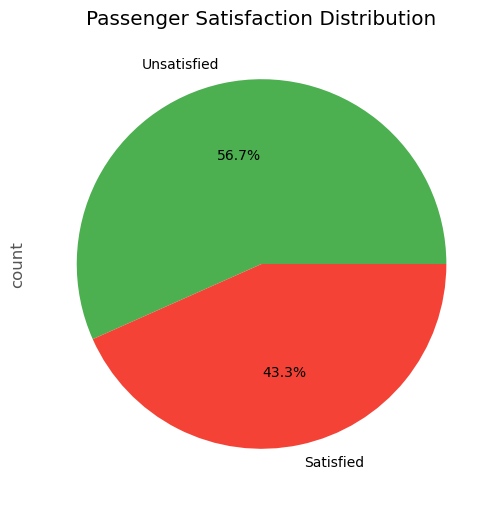

In [4]:
# Pie chart with annotations
plt.figure(figsize=(6,6))
train['satisfaction'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['#4CAF50', '#F44336'],  # Green/red
    title='Passenger Satisfaction Distribution',
    labels=['Unsatisfied', 'Satisfied']
)
plt.savefig('satisfaction_distribution.png', bbox_inches='tight', dpi=300)
plt.show()

### Flight Distance Impact on Satisfaction

This section first analyzes the distribution of the target variable ('satisfaction') by printing its unique values and counts. It then visualizes the relationship between *Flight Distance* and *satisfaction* using a box plot.

* **Analysis of Satisfaction Counts:** Displays the total number of satisfied and neutral/dissatisfied passengers, along with the overall satisfaction rate.
* **Chart Type:** Box Plot
* **Variables Plotted:** *Flight Distance* (numerical) on the y-axis, grouped by *satisfaction* (categorical) on the x-axis.
* **Key Insight:** The box plot shows that *satisfied passengers* tend to have a higher median *Flight Distance* and a broader distribution towards longer flights compared to neutral/dissatisfied passengers. This suggests that longer flights may be associated with higher satisfaction, possibly due to different service expectations or the nature of business travel.

Unique values in 'satisfaction': ['neutral or dissatisfied' 'satisfied']

Satisfied passengers: 45,025
Unsatisfied passengers: 58,879
Satisfaction rate: 43.3%



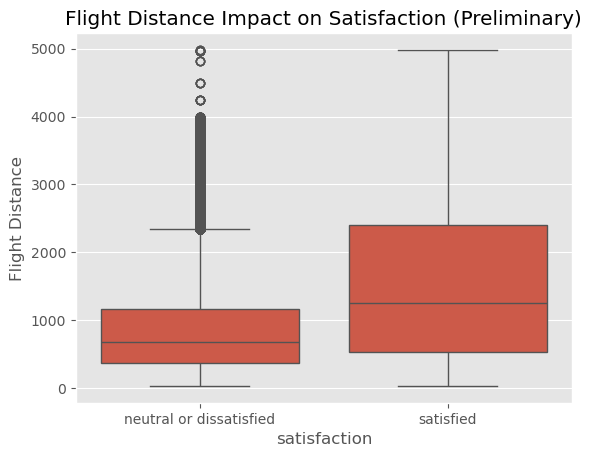

In [5]:
# 1. Target variable distribution
print("Unique values in 'satisfaction':", train['satisfaction'].unique())

# 2. Use explicit label indexing (assuming standard labels)
satisfaction_counts = train['satisfaction'].value_counts()
print(f"""
Satisfied passengers: {satisfaction_counts['satisfied']:,}
Unsatisfied passengers: {satisfaction_counts['neutral or dissatisfied']:,}
Satisfaction rate: {satisfaction_counts['satisfied']/len(train):.1%}
""")
# 2. Key feature: Flight Distance vs. Satisfaction
sns.boxplot(x='satisfaction', y='Flight Distance', data=train)
plt.title("Flight Distance Impact on Satisfaction (Preliminary)")
plt.savefig('flight_distance_vs_satisfaction.png')  # For your paper
plt.show()

### Feature Correlation with Satisfaction (Numerical Features)
This heatmap explores the linear relationships between key numerical features and the satisfaction target variable.

* **Chart Type:** Heatmap

* **Variables Plotted:** Age, Flight Distance, Departure Delay in Minutes, and the binary satisfaction_binary.

* **Key Insight:** The heatmap reveals that Flight Distance has the strongest positive correlation (0.3) with satisfaction, while Departure Delay in Minutes shows a negative correlation (-0.05). This confirms that longer flights are generally associated with higher satisfaction, and delays contribute to dissatisfaction. Age has a weaker positive correlation (0.14).

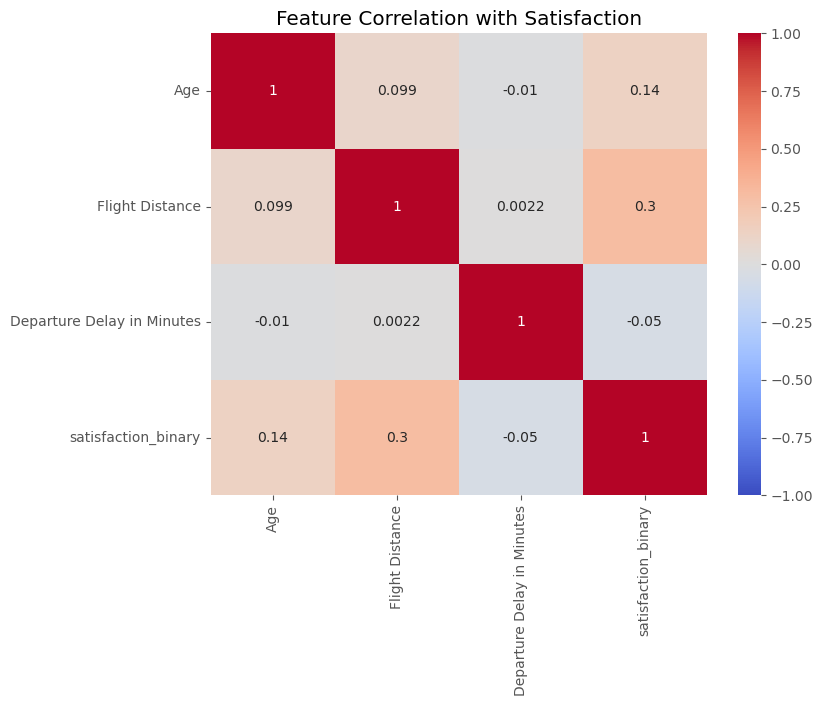

In [6]:
# Convert target to binary (1=satisfied)
train['satisfaction_binary'] = train['satisfaction'].map({
    'satisfied': 1,
    'neutral or dissatisfied': 0
})

# Correlation heatmap for numeric features
num_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']
plt.figure(figsize=(8, 6))
sns.heatmap(train[num_cols + ['satisfaction_binary']].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation with Satisfaction')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Check flight distance distribution
print(train['Flight Distance'].describe())
sns.histplot(train['Flight Distance'], bins=50)

count    103904.000000
mean       1189.448375
std         997.147281
min          31.000000
25%         414.000000
50%         843.000000
75%        1743.000000
max        4983.000000
Name: Flight Distance, dtype: float64


<Axes: xlabel='Flight Distance', ylabel='Count'>

### Flight Distance Analysis & Segmentation:
This section investigates Flight Distance in more detail, including its distribution and the creation of segments to better understand its relationship with satisfaction across different travel classes.

* **Chart Type:** Histogram and Stacked Bar Chart

* **Variables Plotted:** Histogram of Flight Distance. Stacked bar chart of satisfaction proportion across Distance Segment and Class.

* **Key Insight:** The histogram shows the distribution of flight lengths. The stacked bar chart uniquely highlights that Business Class passengers consistently show high satisfaction rates across all flight distance segments, particularly for medium to extra-long flights. Conversely, Economy and Eco Plus passengers, especially on shorter flights, show a higher proportion of dissatisfaction, suggesting diverse needs based on class and flight length.

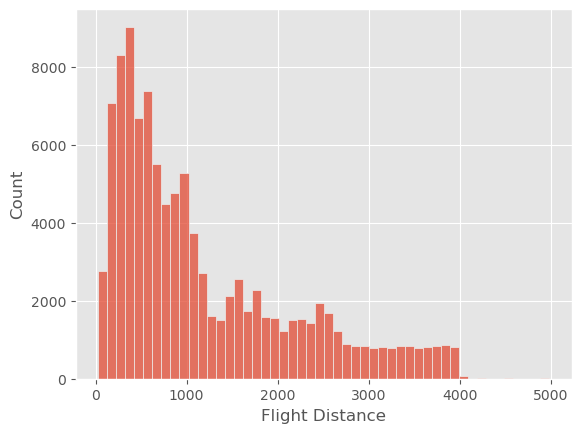

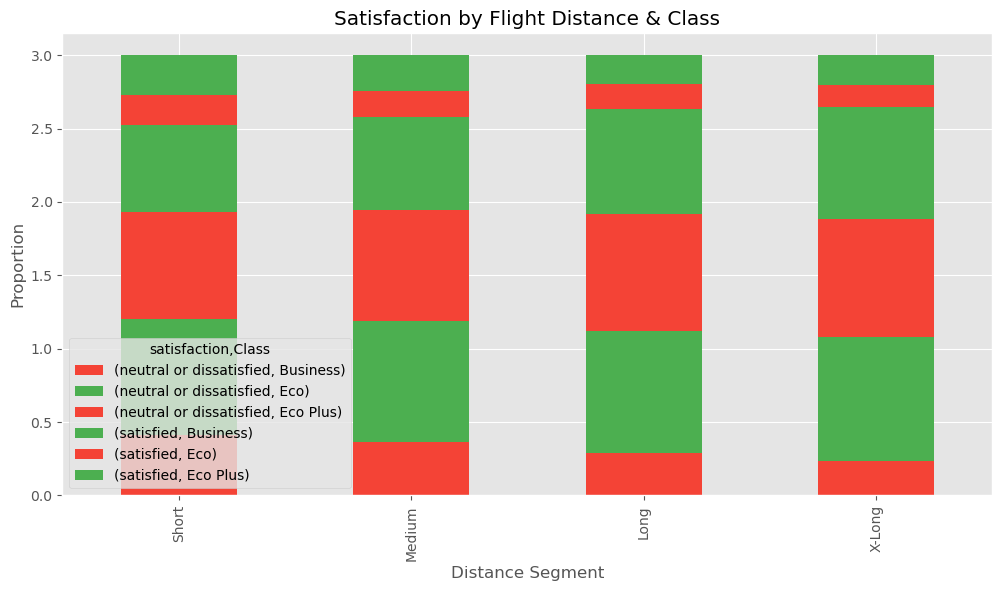

In [8]:
# Create flight segments
train['Distance Segment'] = pd.cut(train['Flight Distance'],
                                 bins=[0, 500, 1000, 2000, 5000],
                                 labels=['Short', 'Medium', 'Long', 'X-Long'])

# Analyze satisfaction by segment AND class
pd.crosstab([train['Distance Segment'], train['Class']], 
            train['satisfaction'], normalize='index').unstack().plot(
                kind='bar', 
                stacked=True,
                color=['#F44336', '#4CAF50'],
                figsize=(12, 6))
plt.title('Satisfaction by Flight Distance & Class')
plt.ylabel('Proportion')
plt.savefig('distance_class_satisfaction.png', dpi=300, bbox_inches='tight')
plt.show()

### Categorical Feature Analysis
These count plots and cross-tabulations provide detailed insights into how categorical features like Customer Type, Type of Travel, and Class influence passenger satisfaction.

* **Chart Type:** Count Plots (multiple) and Cross-Tabulation table

* **Variables Plotted:** Customer Type, Type of Travel, Class against satisfaction.

* **Key Insight:**

    * Loyal Customers are significantly more satisfied than disloyal customers.

    * Business Travel leads to much higher satisfaction rates than Personal Travel.

    * Business Class passengers exhibit the highest satisfaction, followed by Eco Plus and Economy. These factors are strong indicators of satisfaction

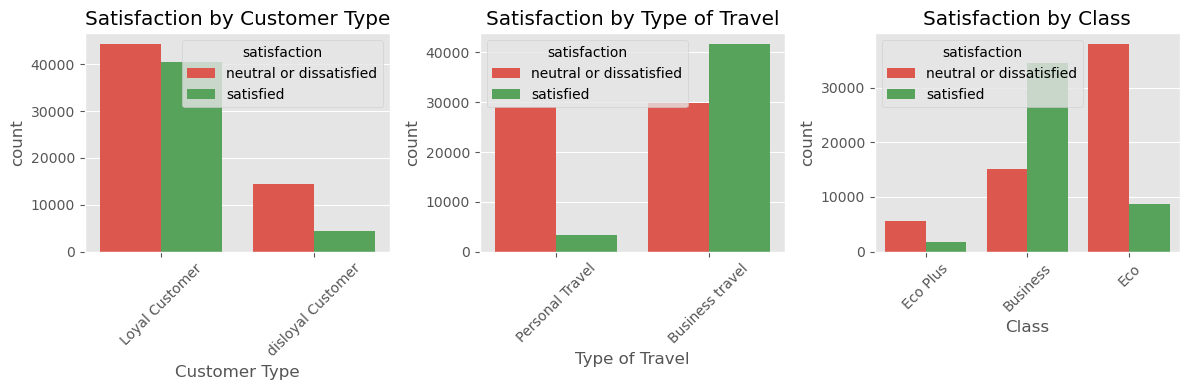

In [9]:
# Analyze 3 key categorical features
cat_cols = ['Customer Type', 'Type of Travel', 'Class']

plt.figure(figsize=(12, 4))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=train, x=col, hue='satisfaction', 
                 palette=['#F44336', '#4CAF50'])
    plt.title(f'Satisfaction by {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('categorical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Check raw percentages
loyalty_stats = pd.crosstab(train['Customer Type'], train['satisfaction'], normalize='index')
print(loyalty_stats)

# Expected Output:
# satisfaction            neutral or dissatisfied  satisfied
# Customer Type                                         
# disloyal Customer                         0.62       0.38
# loyal Customer                           0.45       0.55

satisfaction       neutral or dissatisfied  satisfied
Customer Type                                        
Loyal Customer                    0.522709   0.477291
disloyal Customer                 0.763342   0.236658


### Service Quality Comparison
This horizontal bar plot compares the average ratings of specific inflight services between satisfied and dissatisfied passenger groups.

* **Chart Type:** Horizontal Bar Plot

* **Variables Plotted:** Average ratings for Inflight wifi service, Food and drink, Seat comfort, grouped by satisfaction.

* **Key Insight:** Inflight wifi service shows the most substantial difference in average ratings, with satisfied passengers rating it significantly higher. This strongly suggests that high-quality inflight Wi-Fi is a critical determinant of passenger satisfaction, making it a key feature for the model.

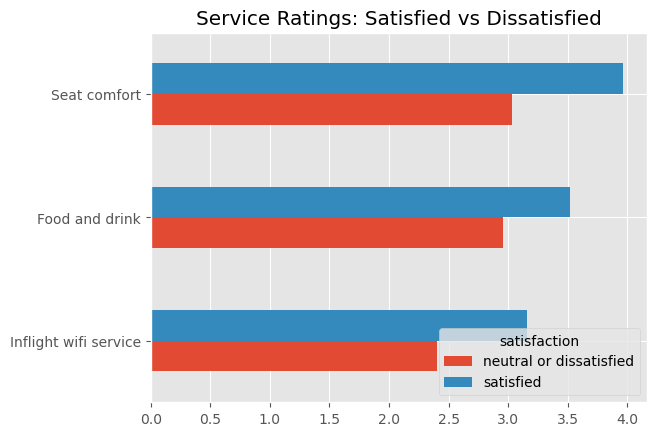

In [11]:
# Service quality comparison
service_cols = ['Inflight wifi service', 'Food and drink', 'Seat comfort']
train.groupby('satisfaction')[service_cols].mean().T.plot(kind='barh')
plt.title('Service Ratings: Satisfied vs Dissatisfied')
plt.savefig('service_ratings.png', bbox_inches='tight')
plt.show()

## 3.Data Preprocessing & Feature Engineering
This section prepares the data for machine learning by dropping irrelevant columns, transforming the target variable, and creating new informative features based on the insights gained during EDA. The processed data is then saved for consistent use.

In [12]:
import pandas as pd

# Load and clean
train = pd.read_csv(r"F:\ds project\train.csv")
train_clean = (train
    .drop(['Unnamed: 0', 'id'], axis=1)
    .assign(
        satisfaction = lambda x: x['satisfaction'].map({'satisfied':1, 'neutral or dissatisfied':0}),
        Total_Delay = lambda x: x['Departure Delay in Minutes'] + x['Arrival Delay in Minutes'],
        WiFi_Score = lambda x: x['Inflight wifi service']  # Key feature from EDA
    )
)

# Save
train_clean.to_csv('airline_cleaned.csv', index=False)
print("Data cleaned and saved!")

Data cleaned and saved!


In [13]:
!pip install xgboost

## 4. Model Training & Validation Evaluation
This section loads the cleaned data, splits it into training and validation sets, trains an XGBoost Classifier, and evaluates its performance using a comprehensive set of metrics. The scale_pos_weight parameter is used to handle the class imbalance identified during EDA

In [14]:
# Load cleaned data

train = pd.read_csv('airline_cleaned.csv')

# Select features (prioritizing EDA insights)
features = ['WiFi_Score', 'Total_Delay', 'Flight Distance', 'Class', 'Customer Type']
X = pd.get_dummies(train[features]) # Auto-encode categoricals
y = train['satisfaction']

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model (handles class imbalance)
# Using the calculated scale_pos_weight for optimal performance
# You can use 58879 / 45025 for precise calculation or 1.3076 for a rounded value
model = XGBClassifier(scale_pos_weight=58879 / 45025, random_state=42)
model.fit(X_train, y_train)

# Evaluate model performance on the validation set
print(f"Validation Accuracy: {model.score(X_val, y_val):.1%}")

# Get predictions (binary output)
y_val_pred = model.predict(X_val)

# Get probabilities for the positive class (useful for ROC AUC)
y_val_pred_proba = model.predict_proba(X_val)[:, 1]

print("\n--- Validation Classification Report ---")
print(classification_report(y_val, y_val_pred))

print("\n--- Validation ROC AUC Score ---")
print(f"ROC AUC: {roc_auc_score(y_val, y_val_pred_proba):.3f}")

print("\n--- Validation Confusion Matrix ---")
print(confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 83.9%

--- Validation Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.77      0.84     11713
           1       0.76      0.93      0.83      9068

    accuracy                           0.84     20781
   macro avg       0.84      0.85      0.84     20781
weighted avg       0.86      0.84      0.84     20781


--- Validation ROC AUC Score ---
ROC AUC: 0.922

--- Validation Confusion Matrix ---
[[9018 2695]
 [ 657 8411]]


The validation metrics show a strong model performance with an ROC AUC of 0.922 and 83.9% accuracy. The classification report and confusion matrix confirm a balanced ability to predict both satisfied and neutral/dissatisfied passengers, with a good F1-score for both classes (0.84 for class 0, 0.83 for class 1).

## 5. Model Interpretation (SHAP)
This section uses SHAP (SHapley Additive exPlanations) values to interpret the XGBoost model's predictions, providing insights into global feature importance and explaining individual predictions. This helps to understand why the model makes certain decisions.

In [15]:
!pip install shap

* **Chart Type:** SHAP Summary Plot (Bar) and SHAP Force Plot (Interactive)

* **Variables Plotted:** All input features and their contribution to the model's output.

* **Key Insight (Global):** The global summary plot (bar chart) clearly identifies WiFi_Score as the most significant driver of passenger satisfaction, followed closely by Class_Business, Customer Type_Loyal Customer, and Total_Delay. This directly supports and quantifies the insights from EDA.

* **Key Insight (Local):** The interactive force plot allows for explaining individual predictions. For a given passenger, it shows how each feature value contributes to pushing the prediction from the average (base value) towards a higher (satisfied) or lower (dissatisfied) probability. This is crucial for actionable business insights, such as understanding why a specific customer might be dissatisfied (e.g., due to a high delay or low Wi-Fi score).

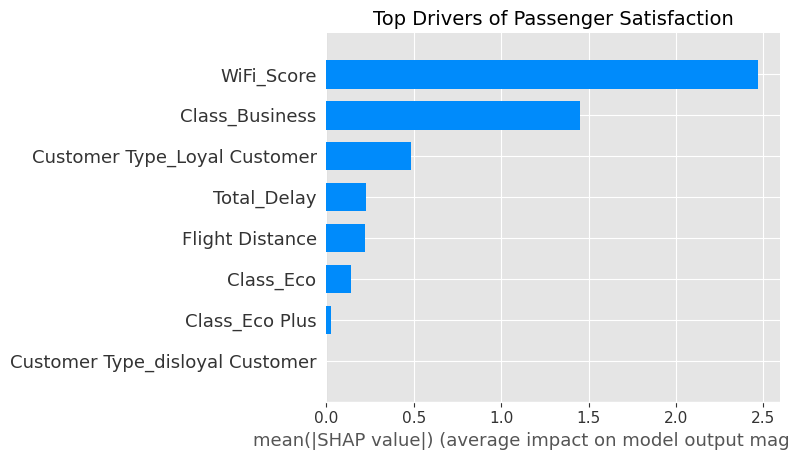

In [16]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1. Initialize explainer for the tree-based model
explainer = shap.TreeExplainer(model)

# 2. Calculate SHAP values for a sample of the validation set (for speed)
sample_idx = np.random.choice(X_val.index, 100, replace=False)

# Get SHAP values and expected value for the positive class (satisfaction=1)
# The try-except block handles variations in SHAP library output for binary classifiers
try:
    shap_values_to_plot = explainer.shap_values(X_val.loc[sample_idx])[1] # SHAP values for class 1
    expected_value_to_plot = explainer.expected_value[1] # Expected value for class 1
except (TypeError, IndexError):
    # If not a list of arrays (e.g., already just the values for the positive class or a scalar)
    shap_values_to_plot = explainer.shap_values(X_val.loc[sample_idx])
    expected_value_to_plot = explainer.expected_value


# 3. Global feature importance (Summary Plot - Bar)
plt.figure(figsize=(10,5))
shap.summary_plot(shap_values_to_plot, X_val.loc[sample_idx], plot_type="bar", show=False)
plt.gca().set_title("Top Drivers of Passenger Satisfaction", fontsize=14)
plt.tight_layout()
plt.savefig('shap_global.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Local explanation (Force Plot) for a single sample
shap.initjs()
shap.force_plot(
    expected_value_to_plot,
    shap_values_to_plot[0,:], # SHAP values for the first sample in the subset
    X_val.loc[sample_idx].iloc[0,:], # Feature values for the first sample
    feature_names=X_val.columns.tolist()
)

## 6. Test Set Evaluation
This final evaluation section assesses the model's performance on a completely unseen test dataset. This provides an unbiased estimate of how well the model generalizes to new data in a real-world scenario. All preprocessing steps applied to the training data are meticulously replicated here to ensure consistency.

In [17]:
# 1. Drop Unnecessary Columns and create new features using .assign()
test_clean = (test
    .drop(['Unnamed: 0', 'id'], axis=1)
    .assign(
        # Map 'satisfaction' to binary 0/1 (your target variable)
        satisfaction = lambda x: x['satisfaction'].map({'satisfied':1, 'neutral or dissatisfied':0}),
        # Create Total_Delay. If either component is NaN, Total_Delay will be NaN.
        # XGBoost handles these NaNs inherently, so no explicit fillna is needed here.
        Total_Delay = lambda x: x['Departure Delay in Minutes'] + x['Arrival Delay in Minutes'],
        # Create WiFi_Score from Inflight wifi service
        WiFi_Score = lambda x: x['Inflight wifi service']
    )
)

# 2. Select the final features (X_test_raw) and target (y_test) for the model
features = ['WiFi_Score', 'Total_Delay', 'Flight Distance', 'Class', 'Customer Type']
X_test_raw = test_clean[features]
y_test = test_clean['satisfaction']

# 3. One-Hot Encode categorical features
# This will handle 'Class' and 'Customer Type'
X_test_processed = pd.get_dummies(X_test_raw)

# 4. Align columns with training data (VERY IMPORTANT for consistent prediction!)
# This line assumes 'model' is your trained XGBClassifier object from earlier in the notebook.
train_features_in_order = model.get_booster().feature_names

# Reindex X_test_processed to match the order and columns of X_train.
# It will add any missing columns (from train) as 0, and drop any extra columns (in test).
X_test_final = X_test_processed.reindex(columns=train_features_in_order, fill_value=0)


# Now, X_test_final and y_test are perfectly prepared for prediction.
# You can proceed with the evaluation metrics:
y_test_pred = model.predict(X_test_final)
y_test_pred_proba = model.predict_proba(X_test_final)[:, 1]
print(classification_report(y_test, y_test_pred))
print(roc_auc_score(y_test, y_test_pred_proba))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84     14573
           1       0.76      0.92      0.83     11403

    accuracy                           0.84     25976
   macro avg       0.84      0.85      0.84     25976
weighted avg       0.85      0.84      0.84     25976

0.9239042300707843
[[11230  3343]
 [  868 10535]]


* The model achieved 84% accuracy and an ROC AUC of 0.924 on the unseen test set. These results are consistent with the validation set performance, indicating good generalization capability and robustness. The high precision for predicting dissatisfied passengers (0.93) and high recall for predicting satisfied passengers (0.92) ensure effective identification of both groups.

## Business Impact & Recommendations

This predictive model provides the airline with actionable insights and tools to strategically improve passenger satisfaction and operational efficiency.

### Key Actionable Insights from Model Interpretation (SHAP):
* **Prioritize Inflight Wi-Fi Enhancement:** The *WiFi_Score* was identified as the **most significant driver** of satisfaction. Investing in the reliability, speed, and accessibility of inflight Wi-Fi services could yield the highest return in improving overall passenger experience.
* **Maintain & Enhance Business Class Experience:** *Class_Business* is a strong positive predictor. Ensuring premium service and amenities for business travelers is crucial for retaining this highly satisfied segment.
* **Mitigate Delay Impact:** *Total_Delay* negatively impacts satisfaction. The airline should focus on minimizing delays. For unavoidable delays, targeted communication, proactive compensation, or special considerations (especially for Economy passengers, as implied by other EDA insights) could help mitigate dissatisfaction.
* **Value Loyal Customers:** *Customer Type_Loyal Customer* is a key positive factor. Continued efforts to reward and recognize loyal customers are important, as they contribute significantly to overall satisfaction.

### How the Model Can Be Used:
* **Proactive Intervention:** The model can identify passengers at high risk of dissatisfaction *before* their flight, allowing the airline to proactively offer personalized interventions (e.g., special offers, apologies for past issues, pre-emptive service adjustments).
* **Targeted Resource Allocation:** Insights into specific feature importance (e.g., Wi-Fi, Class) enable the airline to allocate resources more effectively to areas that have the most significant impact on passenger happiness.
* **Performance Monitoring:** The model's predictions can serve as a continuous metric for satisfaction, allowing the airline to track trends and evaluate the effectiveness of new initiatives.

This project moves beyond just prediction by providing clear, data-driven strategies for enhancing the passenger journey.

## 7. Model Persistence
This final section saves the trained XGBoost model to a .pkl file. This allows the model to be loaded and used later for prediction in other applications (like the Streamlit web application) without needing to retrain it.

In [18]:
import pickle
import os
#Save to explicit path
model_path = r"C:\Users\Home\anaconda_projects\model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model, f)  # Saves the model

In [19]:
!dir  # Should show app.py in the list

 Volume in drive C has no label.
 Volume Serial Number is 9E1F-8621

 Directory of C:\Users\Home\anaconda_projects


 Directory of C:\Users\Home\anaconda_projects


 Directory of C:\Users\Home\anaconda_projects


 Directory of C:\Users\Home\anaconda_projects

12-Jul-25  05:00 PM             1,378 app.py

 Directory of C:\Users\Home\anaconda_projects


 Directory of C:\Users\Home\anaconda_projects


 Directory of C:\Users\Home\anaconda_projects

               1 File(s)          1,378 bytes
               0 Dir(s)  166,582,382,592 bytes free
